In [1]:
%matplotlib inline
import numpy as np
import bayesian_pdes as bpdes
from scipy import stats
import matplotlib.pyplot as plt
import mcmc
import sympy as sp
%load_ext mcmc
%mcmc notebook

# Sheet Parameters

In [2]:
# important helpers!
def cart2pol(points):
    x = points[:,0]
    y = points[:,1]
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return np.column_stack([rho, phi])

def pol2cart(points):
    rho = points[:,0]
    phi = points[:,1]
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return np.column_stack([x, y])

In [3]:
stim_current = 1 # current which we are stimulating with
# code for setting up the stim pattern
stim_pattern = np.zeros((7,8))
for i in xrange(7):
    stim_pattern[i,0] = 1
    stim_pattern[i, i+1] = -1
stim_pattern = stim_pattern*stim_current

In [4]:
likelihood_variance = 1e-4 # variance for the observation model
run_time = 1 # time at which to run the MCMC

# Load Data

In [5]:
data_file = '../data/ST1trial3.DAT'
raw_data = np.loadtxt(data_file)

The data file format is as follows:
* Each row corresponds to a time
* The first element of the row gives the time index of the measurement
* The remaining columns give the measurements for each time
* These are divided into seven blocks.
    - Call the block $i$
    - Within the block the measurements correspond to electrodes $j=1,\dots,8$, $j\neq i$
    - Pair $(i,j)$ represents passing a current between electrode $i$ and electrode $j$ and measuring the voltage.
    - The voltage is measured between the _reference_ electrode at $1$ and the electrode located at $1+i$

_Is there not one too many electrodes here? This implies at some point we measure the voltage between 1 and 2 based on a current driven between 1 and 2._

_Is there a linear independence problem here? I still think there might be._

In [6]:
def data_to_dict(data):
    res = {}
    stims = {}
    for r in data:
        time = r[0]
        other_data = r[1:]
        res[time] = other_data.reshape((7,7))
        stims[time] = stim_pattern
    return res, stims

In [7]:
data_dict, stim_dict = data_to_dict(raw_data)
# quick check to make sure the data dict matches expectation
assert np.all(data_dict[1][0] == raw_data[0][1:8])

# Set Up

In [8]:
from bayesian_pdes.problems import eit

In [9]:
s_x, s_xbar, s_y, s_ybar = sp.symbols('x,xbar,y,ybar')
s_length_scale = sp.symbols('sigma')
kernel = sp.exp(-((s_x - s_xbar)**2 + (s_y-s_ybar)**2) / (2.*s_length_scale**2))
symbols = [[s_x, s_y], [s_xbar, s_ybar], [s_length_scale]]

In [10]:
op_system_factory = eit.EITFactory(kernel, symbols[0], symbols[1], symbols[2])

## Define the collocation grid

In [11]:
r = 1.0 # todo: just assume a unit radius, is this okay?
n_in_shell = 5

In [12]:
def construct_shell(radii):
    r_spacing = radii[1] - radii[0]
    coords = [np.array([[0.,0.]])]
    for r in radii:
        # at each 'shell' we want a roughly equal number of theta around the diameter.
        # each theta should be about r_spacing apart
        n_theta = np.round(2*np.pi*r / r_spacing)
        thetas = np.linspace(0, 2*np.pi, n_theta+1)[:-1]
        x = np.cos(thetas)
        y = np.sin(thetas)
        coords.append(r*np.c_[x,y])
    coords = np.concatenate(coords)
    return coords


In [13]:
shell_radii = np.linspace(0, r, n_in_shell)[1:-1]
design_int = construct_shell(shell_radii)

In [14]:
n_bdy = 32
bdy_theta = np.linspace(0, 2*np.pi, n_bdy+1)
design_bdy = pol2cart(np.c_[np.ones(n_bdy), bdy_theta[:-1]]) 

# define the mapping from boundary collocation point to sensor
bdy_sensor_skip = 4
sensor_ixs = np.arange(0, len(design_bdy), bdy_sensor_skip)
is_sensor_flags = np.in1d(np.arange(len(design_bdy)), sensor_ixs)

sensor_xy = design_bdy[is_sensor_flags]
non_sensor_xy = design_bdy[~is_sensor_flags]
print('{} sensors'.format(len(sensor_xy)))
print('{} non-sensors'.format(len(non_sensor_xy)))

8 sensors
24 non-sensors


In [15]:
# for now we impose the BC only at the sensor locations and impose the interior condition at non-sensor bdy points
modified_design_int = np.row_stack([design_int, non_sensor_xy])
modified_design_bdy = sensor_xy

In [16]:
full_design = np.row_stack([modified_design_int, modified_design_bdy])

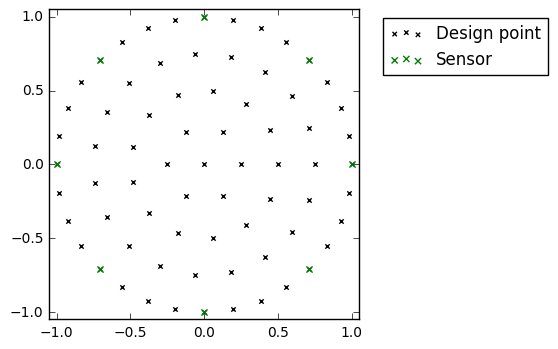

In [17]:
# plot design points
plt.figure(figsize=(4,4))
plt.scatter(design_int[:,0], design_int[:,1], marker='x', color='black', s=10)
plt.scatter(design_bdy[:,0], design_bdy[:,1], marker='x', color='black', s=10, label='Design point')
plt.scatter(sensor_xy[:,0], sensor_xy[:,1], marker='x', color='green', label='Sensor')
plt.xlim(-r*1.05,r*1.05);plt.ylim(-r*1.05,r*1.05)
plt.legend(loc=2, bbox_to_anchor=(1.05,1))

In [18]:
def theta_to_kappa(theta, sz_int, sz_bdy):
    kappa_int = theta[:sz_int]
    kappa_bdy = theta[sz_int:sz_int+sz_bdy]
    grad_kappa_x = theta[sz_int+sz_bdy:2*sz_int+sz_bdy]
    grad_kappa_y = theta[2*sz_int+sz_bdy:]
    return kappa_int, kappa_bdy, grad_kappa_x, grad_kappa_y

## Define the Potential

In [19]:

# define the observations skeleton
obs = [
    (modified_design_int, None),
    (modified_design_bdy, None)
]
# todo: choose this in a more principled way
length_scale = 0.4
fun_args = np.array([length_scale])

In [20]:
def phi(theta, debug=False):
    # first solve forward
    kappa_int, kappa_bdy, grad_kappa_x, grad_kappa_y = theta_to_kappa(theta, 
                                                                      modified_design_int.shape[0], 
                                                                      modified_design_bdy.shape[0])
    op_system = op_system_factory.get_operator_system(
        kappa_int,
        kappa_bdy,
        grad_kappa_x,
        grad_kappa_y,
        use_cache=True
    )
    posterior = bpdes.collocate(
        op_system.operators,
        op_system.operators_bar,
        obs,
        op_system,
        fun_args,
        inverter='np'
    )
    # now determine voltage at the sensor locations
    mu_mult, Sigma = posterior.no_obs_posterior(sensor_xy[1:])
    # now need to iterate the stim patterns and compute the residual
    data = data_dict[run_time]
    stim = stim_dict[run_time]
    rhs_int = np.zeros((len(modified_design_int), 1))
        
    likelihood_cov = Sigma + likelihood_variance*np.eye(Sigma.shape[0])
    likelihood_dist = stats.multivariate_normal(np.zeros(Sigma.shape[0]), likelihood_cov)
    
    likelihood = 0
    for voltage, current in zip(data, stim):
        rhs_bdy = current[:,None]
        rhs = np.row_stack([rhs_int, rhs_bdy])
        
        model_voltage = np.dot(mu_mult, rhs)
        
        this_likelihood = likelihood_dist.logpdf(voltage.ravel() - model_voltage.ravel())
        if debug:
            print("Model voltages: {}".format(model_voltage.ravel()))
            print("True voltages: {}".format(voltage.ravel()))
            print("Likelihood: {}".format(this_likelihood))
        likelihood += this_likelihood
    return -likelihood

## Set up Proposal Matrix

In [21]:
proposal_kernel = kernel
def diff_x(k):
    return k.diff(s_x)
def diff_y(k):
    return k.diff(s_y)
def diff_x_bar(k):
    return k.diff(s_xbar)
def diff_y_bar(k):
    return k.diff(s_ybar)

proposal_op_system = bpdes.operator_compilation.sympy_gram.compile_sympy(
    [diff_x, diff_y], 
    [diff_x_bar, diff_y_bar], 
    proposal_kernel,
    symbols
)

In [22]:
proposal_cov = bpdes.collocation.compute_operator_matrix(
    [(), diff_x, diff_y],
    [(), diff_x_bar, diff_y_bar],
    [full_design, modified_design_int, modified_design_int],
    [full_design, modified_design_int, modified_design_int],
    proposal_op_system,
    fun_args
)

In [28]:
mcmc.pcn.sqrtm_mode = mcmc.pcn.SQRTM_SVD
proposal = mcmc.pcn.proposal(0.5, proposal_cov)
kappa_0 = np.random.multivariate_normal(np.zeros(proposal_cov.shape[0]), proposal_cov)

In [ ]:
proposals, acceptances = mcmc.pCN(100000, proposal, phi, kappa_0)

None
notebook
